In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
from sklearn import linear_model
from surprise import SVD, Reader, Dataset
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# extract info
# assignment 1 format: ('u93397390', 'b52690052', 3) user id, book id, rating
ratings_df = pd.read_csv('./dataset/ratings_training.csv').get(['username', 'anime_id'])
ratings_df = ratings_df.rename(columns={'username':'user', 'anime_id':'item'})
ratings_df

,user,item
0,tamama_kuroyuki,14817
1,quazzaar,2449
2,abhay_shinigami,25013
3,xever,1566
4,Equintus,5030
...,...,...
199995,Nara-Sama,4437
199996,rxkxt,164
199997,Synizta,10162
199998,SlyVengeance,31798


In [7]:
anime_info = pd.read_csv('./dataset/anime_info.csv').drop(columns=['Unnamed: 0'])
anime_info.sort_values(by='aired_from_year', ascending=False).head()

,anime_id,title,title_english,title_japanese,title_synonyms,type,source,episodes,status,airing,...,premiered,broadcast,related,producer,licensor,studio,genre,duration_min,aired_from_year,genre_list
1095,34607,Lostorage Conflated WIXOSS,NaN,Lostorage conflated WIXOSS,NaN,TV,Card game,0,Currently Airing,True,...,Spring 2018,Saturdays at 00:30 (JST),"{'Prequel': [{'mal_id': 33197, 'type': 'anime'...",NaN,NaN,J.C.Staff,"Game, Psychological",23.000000,2018.0,"['Game', 'Psychological']"
4886,36470,Tada-kun wa Koi wo Shinai,Tada Never Falls in Love,多田くんは恋をしない,Tada Doesn&#039;t Fall in Love,TV,Original,12,Currently Airing,True,...,Spring 2018,Thursdays at 21:00 (JST),[],NaN,Sentai Filmworks,Doga Kobo,"Slice of Life, Comedy, Romance",23.000000,2018.0,"['Slice of Life', 'Comedy', 'Romance']"
798,37244,Gan Gan Ganko-chan 2nd Season,NaN,がん がん がんこちゃん 第2期,NaN,TV,Original,8,Finished Airing,False,...,Winter 2018,Sundays at 07:55 (JST),"{'Prequel': [{'mal_id': 34488, 'type': 'anime'...",NaN,NaN,10Gauge,"Sci-Fi, Comedy, Kids",5.000000,2018.0,"['Sci-Fi', 'Comedy', 'Kids']"
210,36793,3D Kanojo: Real Girl,NaN,３Ｄ彼女 リアルガール,3D Girlfriend,TV,Manga,12,Currently Airing,True,...,Spring 2018,Wednesdays at 01:59 (JST),"{'Adaptation': [{'mal_id': 50767, 'type': 'man...",NaN,Sentai Filmworks,Hoods Entertainment,"Romance, School, Shoujo",22.000000,2018.0,"['Romance', 'School', 'Shoujo']"
214,37104,Slow Start: Web Yokoku Movie,NaN,『スロウスタート』Web予告ムービー,NaN,ONA,4-koma manga,11,Finished Airing,False,...,NaN,NaN,"{'Other': [{'mal_id': 35540, 'type': 'anime', ...",NaN,NaN,A-1 Pictures,Slice of Life,0.633333,2018.0,['Slice of Life']


In [8]:
# add column for number of years since release
anime_updated = anime_info.assign(years_since_release=2018-anime_info['aired_from_year'])
anime_updated

,anime_id,title,title_english,title_japanese,title_synonyms,type,source,episodes,status,airing,...,broadcast,related,producer,licensor,studio,genre,duration_min,aired_from_year,genre_list,years_since_release
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,TV,Manga,12,Finished Airing,False,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen",24.0,2012.0,"['Comedy', 'Supernatural', 'Romance', 'Shounen']",6.0
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,TV,Manga,26,Finished Airing,False,...,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen",24.0,2007.0,"['Comedy', 'Parody', 'Romance', 'School', 'Sho...",11.0
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",TV,Manga,51,Finished Airing,False,...,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo",24.0,2008.0,"['Comedy', 'Magic', 'School', 'Shoujo']",10.0
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,TV,Original,38,Finished Airing,False,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy",16.0,2002.0,"['Comedy', 'Drama', 'Magic', 'Romance', 'Fanta...",16.0
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,TV,Manga,25,Finished Airing,False,...,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen",24.0,2012.0,"['Comedy', 'Drama', 'Romance', 'Shounen']",6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5806,37894,Ling Yu 4th Season,NaN,灵域 第四季,"Spiritual Domain Fourth Season, Spiritual Field 4",ONA,Novel,12,Finished Airing,False,...,NaN,"{'Prequel': [{'mal_id': 36791, 'type': 'anime'...",iQIYI,NaN,Haoliners Animation League,Fantasy,13.0,2016.0,['Fantasy'],2.0
5807,37886,Wo Shi Jiang Xiaobai (2018),I&#039;m Joybo OVA,我是江小白 小剧场,Wo Shi Jiang Xiao Bai: Xiao Ju Chang,ONA,Original,1,Finished Airing,False,...,NaN,"{'Prequel': [{'mal_id': 36775, 'type': 'anime'...",NaN,NaN,2:10 Animation,"Slice of Life, Drama, Romance",0.0,2018.0,"['Slice of Life', 'Drama', 'Romance']",0.0
5808,37255,Genki Genki Non-tan: Obake Mura Meiro,NaN,げんきげんきノンタン おばけむらめいろ,NaN,OVA,Original,1,Finished Airing,False,...,NaN,"{'Prequel': [{'mal_id': 25619, 'type': 'anime'...",NaN,NaN,Polygon Pictures,"Music, Kids",35.0,2015.0,"['Music', 'Kids']",3.0
5809,35229,Mr. Men Little Miss,Mr. Men Little Miss,Mr. Men Little Miss / ミスターメン リトルミス,NaN,ONA,Picture book,0,Currently Airing,True,...,NaN,[],NaN,NaN,Sanrio,Kids,2.0,2013.0,['Kids'],5.0


In [9]:
# add number watched by user as feature? trying age as well
user_info = pd.read_csv('./dataset/user_data.csv')
user_watched = user_info.get(['username', 'user_completed', 'age']).rename(columns={'username':'user'})
user_watched

,user,user_completed,age
0,karthiga,49,34
1,Damonashu,195,33
2,bskai,414,34
3,terune_uzumaki,5,26
4,Bas_G,114,25
...,...,...,...
108706,isoann,213,27
108707,bumcakee,116,26
108708,Scarlet95,103,29
108709,Torasori,239,26


In [10]:
# add anime popularity, score as feature? trying years since release
popularity = anime_updated.get(['anime_id', 'popularity', 'score', 'years_since_release']).sort_values(by='popularity', ascending=True).rename(columns={'anime_id':'item'})
popularity

,item,popularity,score,years_since_release
3307,1535,1,8.67,12.0
3392,16498,2,8.49,5.0
2612,11757,3,7.64,6.0
1117,5114,4,9.25,9.0
3673,30276,5,8.73,3.0
...,...,...,...,...
5792,37859,14426,0.00,1.0
5788,37860,14427,0.00,1.0
5784,37814,14429,0.00,0.0
5803,37493,14466,4.00,0.0


In [128]:
all_info = ratings_df.merge(popularity, on='item', how='left')
all_info = all_info.merge(user_watched, on='user')
# all_info = all_info.rename(columns={'username':'user', 'anime_id':'item'})
all_info = all_info.fillna(0)
all_info

,user,item,popularity,score,user_completed
0,tamama_kuroyuki,14817,3758.0,7.22,2387
1,quazzaar,2449,2207.0,8.17,602
2,abhay_shinigami,25013,165.0,8.19,262
3,xever,1566,1187.0,8.19,682
4,Equintus,5030,713.0,7.13,220
...,...,...,...,...,...
199995,Nara-Sama,4437,667.0,7.41,388
199996,rxkxt,164,79.0,8.80,44
199997,Synizta,10162,256.0,8.52,461
199998,SlyVengeance,31798,184.0,7.59,170


In [11]:
users = ratings_df.get('user')
# scores = ratings_df.get('my_score')
animes = ratings_df.get('item')

In [12]:
allRatings = []
trueScores = []
for i in range(ratings_df.shape[0]):
    u = users.iloc[i]
    a = animes.iloc[i]
    # r = scores.iloc[i]
    entry = (u, a)
    allRatings.append(entry)
    # trueScores.append(r)
len(allRatings)

200000

In [6]:
allRatings[0]

('Sara2604', 530, 6)

In [13]:
# ratingsTrain = allRatings[:190000]
ratingsValid = allRatings[190000:]
len(ratingsValid)

10000

In [14]:
ratingsSubset = allRatings[:100000]

In [68]:
len(ratingsTrain)

30000

In [66]:
len(ratingsValid)

10000

In [15]:
usersPerItem = defaultdict(set) # Maps an anime to the users who rated (watched) it
itemsPerUser = defaultdict(set) # Maps a user to the animes that they rated (watched)

# for d in ratingsTrain:
for d in ratingsSubset:
    user,item = d[0], d[1]
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)

In [16]:
pos_interactions = [] # [(u_1, i_1, True), (u_2, i_2, True), ...] True means the user have interacted w/ item.
# for r in ratingsValid:
for r in ratingsSubset:
    entry = (r[0], r[1], True)
    pos_interactions.append(entry)

In [17]:
len(pos_interactions)

100000

In [18]:
# get list of all anime (in training set)
allAnime = []
# for r in ratingsTrain:
for r in ratingsSubset:
    if r[1] not in allAnime:
        allAnime.append(r[1])

In [19]:
len(allAnime)

4859

In [14]:
pos_interactions[0]

('tamama_kuroyuki', 14817, True)

In [20]:
# generate neg samples for validation
pos_testing = [] # [(u_1, i_1, True), (u_2, i_2, True), ...] True means the user have interacted w/ item.
for r in ratingsValid:
    entry = (r[0], r[1], True)
    pos_testing.append(entry)

In [31]:
len(pos_testing)

10000

In [21]:
# generate negative samples (users matched with anime they did NOT watch)
def generate_training_neg():
    validTraining = pos_interactions[:]
    for i in pos_interactions:
        username = i[0] # retrieve username
        # get list of anime that user has watched
        watched = itemsPerUser[username]
        # get list of books that user has NOT watched
        unwatched = allAnime.copy()
        for a in watched:
            if a in unwatched:
                unwatched.remove(a)
        # randomly sample an anime user has not watched, append to validation set
        sample_unwatched = random.sample(unwatched, 1)
        validTraining.append((username, sample_unwatched[0], False)) # false bc user has not read book
    return validTraining

In [22]:
# generate negative samples (users matched with anime they did NOT watch)
def generate_testing_neg():
    validTesting = pos_testing[:]
    for i in pos_testing:
        username = i[0] # retrieve username
        # get list of anime that user has watched (in training set)
        watched = itemsPerUser[username]
        # get list of books that user has NOT watched
        unwatched = allAnime.copy()
        for a in watched:
            if a in unwatched:
                unwatched.remove(a)
        # randomly sample an anime user has not watched, append to validation set
        sample_unwatched = random.sample(unwatched, 1)
        validTesting.append((username, sample_unwatched[0], False)) # false bc user has not read book
    return validTesting

In [23]:
watch_training = generate_training_neg()
len(watch_training)

200000

In [24]:
testing_samples = generate_testing_neg()
len(testing_samples)

20000

In [51]:
itemsPerUser['Kenji06']

{469, 1366, 6114, 11783, 16123, 17437, 25517, 25879}

In [25]:
# Jaccard similarity
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [18]:
allRatings[0]

('tamama_kuroyuki', 14817, 7)

In [19]:
itemsPerUser['Sara2604']

{339, 23281}

In [40]:
# predictor from Assignment 1 -- combo of Jaccard similarity and popularity threshold
def watch_predictor(user, item):
    maxSim = 0
    users = usersPerItem[item] # all users who have watched given item
    # user vs user similarity
    for b in itemsPerUser[user]: # all anime watched by given user
        userSim = Jaccard(users,usersPerItem[b]) # similarity between given user and all other users who've watched given item
        if userSim > maxSim:
            maxSim = userSim
    pred = 0
    # sim: 0.013, len: 40
    # if maxSim > sim_thresh or len(usersPerItem[item]) > len_thresh:
    if maxSim > 0.12775510204081633 or len(usersPerItem[item]) > 35: #or maxGenreSim > 0.013
        pred = 1
    return pred

In [27]:
def CosineSet(s1, s2):
    # Not a proper implementation, operates on sets so correct for interactions only
    numer = len(s1.intersection(s2))
    denom = math.sqrt(len(s1)) * math.sqrt(len(s2))
    if denom == 0:
        return 0
    return numer / denom

In [28]:
# cosine similarity predictor
def cosine_predictor(user, item):
    maxSim = 0
    users = usersPerItem[item] # all users who have watched given item
    for b in itemsPerUser[user]: # all anime watched by given user
        userSim = CosineSet(users,usersPerItem[b]) # similarity between given user and all other users who've watched given item
        if userSim > maxSim:
            maxSim = userSim
    pred = 0
    # sim: 0.013, len: 40
    # if maxSim > sim_thresh or len(usersPerItem[item]) > len_thresh:
    if maxSim > 0.12775510204081633 or len(usersPerItem[item]) > 36:
        pred = 1
    return pred

In [23]:
trueScores[0:5]

[7, 8, 9, 7, 0]

In [29]:
# training_preds = [watch_predictor(d[0], d[1]) for d in training_samples]
training_preds = [watch_predictor(d[0], d[1]) for d in watch_training]

In [41]:
testing_preds = [watch_predictor(d[0], d[1]) for d in testing_samples]

In [31]:
# compare predictions with validation set
validLabels = [d[2] for d in testing_samples]
# validLabels = [d[2] for d in watch_training]
def get_num_correct(predictions):
    num_correct = 0
    for i in range(len(testing_samples)): # compare predictions vs actual 
    # for i in range(len(watch_training)):
        pred = predictions[i] # prediction
        actual = validLabels[i]
        if pred == actual: # book was correctly predicted as read/unread
            num_correct += 1
    return num_correct

In [42]:
# evaluate predictions
correct = get_num_correct(training_preds)
# accuracy = correct / len(training_samples)
accuracy = correct / len(watch_training)
print("correct:", correct, "accuracy:", accuracy)

correct: 10000 accuracy: 0.05


In [43]:
# evaluate predictions
correct = get_num_correct(testing_preds)
# accuracy = correct / len(training_samples)
accuracy = correct / len(testing_preds)
print("correct:", correct, "accuracy:", accuracy)

correct: 14355 accuracy: 0.71775


In [37]:
# best accuracy: 0.7469, best jaccard threshold: 0.048367346938775514
# best accuracy: 0.74885, best popularity threshold: 35.0

In [48]:
# test different thresholds
thres_vals = np.linspace(0.02, 0.9, num=50)
accuracies = []
best_acc = 0
best_thres = -1
for val in thres_vals:
    # generate predictions based off max jaccard val
    predictions = [watch_predictor(d[0], d[1], val) for d in training_samples]
    correct_pred = get_num_correct(predictions) # compare with actual
    # compute accuracy 
    acc = correct_pred / 20000
    accuracies.append(acc)
    if acc > best_acc: # if accuracy is better than current, update and store threshold
        best_acc = acc
        best_thres = val
print(f"best accuracy: {best_acc}, best threshold: {best_thres}")

best accuracy: 0.74885, best threshold: 0.12775510204081633


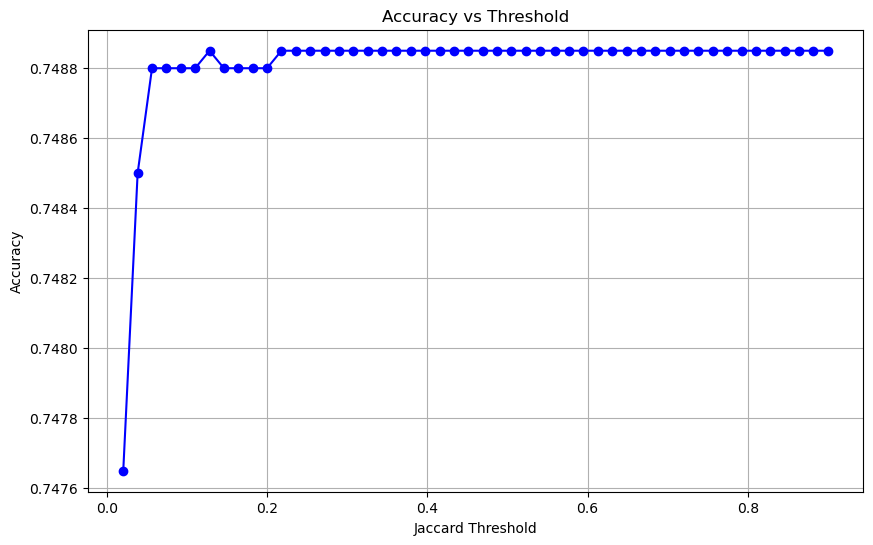

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(thres_vals, accuracies, marker='o', color='b')
plt.xlabel("Jaccard Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Threshold")
plt.grid(True)
plt.show()

In [44]:
cosine_preds = [cosine_predictor(d[0], d[1]) for d in testing_samples]
# cosine_preds = [cosine_predictor(d[0], d[1]) for d in watch_training]
# evaluate predictions
cosine_correct = get_num_correct(cosine_preds)
cosine_acc = cosine_correct / len(testing_samples)
# cosine_acc = cosine_correct / len(watch_training)
print("correct:", cosine_correct, "accuracy:", cosine_acc)

correct: 14324 accuracy: 0.7162


In [15]:
# benchmarks
# predict read randomly
def random_pred():
    pred = random.sample([0, 1], 1)
    return pred[0]

In [37]:
# generate random preds
random_preds = [random_pred() for d in training_samples]
# evaluate
random_correct = get_num_correct(random_preds)
random_accuracy = random_correct / len(random_preds)
print("random correct:", random_correct, "random accuracy:", random_accuracy)

random correct: 9906 random accuracy: 0.4953


In [38]:
training_samples[0]

('SayaViking', 187, True)

In [39]:
# Copied from baseline code -- get set of animes in top 50%
animeCount = defaultdict(int)
totalWatched = 0

for user,anime,_ in training_samples:
    animeCount[anime] += 1
    totalWatched += 1

mostPopular = [(animeCount[x], x) for x in animeCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalWatched/2: break

In [40]:
baseline_correct = 0
for b in training_samples:
    anime = b[1]
    if anime in list(return1): # anime was predicted as watched
        # prediction was correct (anime was watched - True)
        if b[2] == True:
            baseline_correct += 1
        # otherwise prediction was incorrect (anime wasn't watched)
    else: # anime was predicted as unwatched
        if b[2] == False:
            baseline_correct += 1
baseline_correct

13973

In [41]:
baseline_acc= baseline_correct / len(training_samples)
print("baseline accuracy:", baseline_acc)

baseline accuracy: 0.69865


In [129]:
all_info

,user,item,popularity,score,user_completed
0,tamama_kuroyuki,14817,3758.0,7.22,2387
1,quazzaar,2449,2207.0,8.17,602
2,abhay_shinigami,25013,165.0,8.19,262
3,xever,1566,1187.0,8.19,682
4,Equintus,5030,713.0,7.13,220
...,...,...,...,...,...
199995,Nara-Sama,4437,667.0,7.41,388
199996,rxkxt,164,79.0,8.80,44
199997,Synizta,10162,256.0,8.52,461
199998,SlyVengeance,31798,184.0,7.59,170


In [45]:
X_users = []
X_items = []
y = []
for i in range(len(watch_training)):
    entry = watch_training[i]
    user = entry[0]
    item = entry[1]
    X_users.append(user)
    X_items.append(item)
    y.append(entry[2])
print(len(X_users), len(X_items), X_users[0], y[0])

200000 200000 tamama_kuroyuki True


In [46]:
Xtest_users = []
Xtest_items = []
ytest= []
for i in range(len(testing_samples)):
    entry = testing_samples[i]
    user = entry[0]
    item = entry[1]
    Xtest_users.append(user)
    Xtest_items.append(item)
    ytest.append(entry[2])
print(len(Xtest_users), len(Xtest_items), Xtest_items[0], ytest[0])

20000 20000 6324 True


In [47]:
watch_data = pd.DataFrame()
watch_data = watch_data.assign(user=X_users, item=X_items, interaction=y)
watch_data

,user,item,interaction
0,tamama_kuroyuki,14817,True
1,quazzaar,2449,True
2,abhay_shinigami,25013,True
3,xever,1566,True
4,Equintus,5030,True
...,...,...,...
199995,Suanko,32065,False
199996,DraConia,19195,False
199997,Randochi,1770,False
199998,Lawlliet,2963,False


In [41]:
user_watched.head()

,user,user_completed,age
0,karthiga,49,34
1,Damonashu,195,33
2,bskai,414,34
3,terune_uzumaki,5,26
4,Bas_G,114,25


In [70]:
training_with_features = watch_data.merge(user_watched, on='user')
training_with_features = training_with_features.merge(popularity, on='item', how='left')
training_with_features = training_with_features.fillna(0)
training_with_features

,user,item,interaction,user_completed,age,popularity,score,years_since_release
0,tamama_kuroyuki,14817,True,2387,34,3758.0,7.22,4.0
1,quazzaar,2449,True,602,28,2207.0,8.17,13.0
2,abhay_shinigami,25013,True,262,28,165.0,8.19,4.0
3,xever,1566,True,682,32,1187.0,8.19,12.0
4,Equintus,5030,True,220,28,713.0,7.13,9.0
...,...,...,...,...,...,...,...,...
199995,Suanko,32065,False,892,35,8976.0,6.04,3.0
199996,DraConia,19195,False,145,31,2292.0,7.55,4.0
199997,Randochi,1770,False,101,34,0.0,0.00,0.0
199998,Lawlliet,2963,False,508,33,677.0,7.77,11.0


In [115]:
# Encode users and items
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

watch_data['user_encoded'] = user_encoder.fit_transform(watch_data['user'])
# watch_data['item_encoded'] = item_encoder.fit_transform(watch_data['item'])

# Use encoded features
naiveXtrain = watch_data[['user_encoded', 'item']]
# y = watch_data['interaction']  # 1 for watched, 0 for not watched
naiveXtrain

,user_encoded,item
0,47728,14817
1,45225,2449
2,33727,25013
3,49599,1566
4,8745,5030
...,...,...
199995,28405,18679
199996,7829,33419
199997,23954,689
199998,16567,2158


In [71]:
# with additional features
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

scaler = StandardScaler()
training_with_features[['user_completed', 'popularity', 'score']] = scaler.fit_transform(
    training_with_features[['user_completed', 'popularity', 'score']]
)
training_with_features['user_encoded'] = user_encoder.fit_transform(training_with_features['user'])
# watch_data['item_encoded'] = item_encoder.fit_transform(watch_data['item'])

# Use encoded features
Xtrain = training_with_features[['user_encoded', 'item', 'user_completed', 'popularity', 'score', 'years_since_release']]

In [72]:
Xtrain

,user_encoded,item,user_completed,popularity,score,years_since_release
0,47728,14817,3.883220,1.098511,0.316830,4.0
1,45225,2449,0.245999,0.281222,0.668838,13.0
2,33727,25013,-0.446805,-0.794796,0.676249,4.0
3,49599,1566,0.409011,-0.256260,0.676249,12.0
4,8745,5030,-0.532387,-0.506031,0.283482,9.0
...,...,...,...,...,...,...
199995,28405,32065,0.836920,3.848100,-0.120402,3.0
199996,7829,19195,-0.685211,0.326012,0.439106,4.0
199997,23954,1770,-0.774868,-0.881741,-2.358435,0.0
199998,16567,2963,0.054459,-0.525001,0.520624,11.0


In [64]:
testing_df = pd.DataFrame()
testing_df = testing_df.assign(user=Xtest_users, item=Xtest_items, interaction=ytest)
testing_df

,user,item,interaction
0,Milk_is_Special,6324,1
1,Edoarudo,24365,1
2,ExTaSsy,6919,1
3,lagger277,11757,1
4,ImNotHere,25013,1
...,...,...,...
19995,Nara-Sama,23551,0
19996,rxkxt,10444,0
19997,Synizta,7079,0
19998,SlyVengeance,13851,0


In [73]:
testing_with_features = testing_df.merge(user_watched, on='user')
testing_with_features = testing_with_features.merge(popularity, on='item', how='left')
testing_with_features = testing_with_features.fillna(0)
testing_with_features

,user,item,interaction,user_encoded,user_completed,age,popularity,score,years_since_release
0,Milk_is_Special,6324,1,3479,535,27,0.0,0.00,0.0
1,Edoarudo,24365,1,1460,332,30,2689.0,7.54,4.0
2,ExTaSsy,6919,1,1602,113,28,2800.0,6.46,7.0
3,lagger277,11757,1,7482,291,25,3.0,7.64,6.0
4,ImNotHere,25013,1,2239,162,26,165.0,8.19,4.0
...,...,...,...,...,...,...,...,...,...
19995,Nara-Sama,23551,0,3730,388,37,3879.0,6.01,4.0
19996,rxkxt,10444,0,8231,44,29,2983.0,7.35,7.0
19997,Synizta,7079,0,5148,461,31,1390.0,6.42,8.0
19998,SlyVengeance,13851,0,4963,170,26,0.0,0.00,0.0


In [74]:
testing_with_features[['user_completed', 'popularity', 'score']] = scaler.fit_transform(
    testing_with_features[['user_completed', 'popularity', 'score']]
)
testing_with_features['user_encoded'] = user_encoder.fit_transform(testing_with_features['user'])

# Use encoded features
Xtest = testing_with_features[['user_encoded', 'item', 'user_completed', 'popularity', 'score', 'years_since_release']]
Xtest

,user_encoded,item,user_completed,popularity,score,years_since_release
0,3479,6324,0.113660,-0.873523,-2.306030,0.0
1,1460,24365,-0.300802,0.544645,0.440716,4.0
2,1602,6919,-0.747931,0.603186,0.047283,7.0
3,7482,11757,-0.384511,-0.871941,0.477145,6.0
4,2239,25013,-0.647889,-0.786503,0.677505,4.0
...,...,...,...,...,...,...
19995,3730,23551,-0.186467,1.172247,-0.116647,4.0
19996,8231,10444,-0.888808,0.699700,0.371501,7.0
19997,5148,7079,-0.037424,-0.140442,0.032711,8.0
19998,4963,13851,-0.631555,-0.873523,-2.306030,0.0


In [67]:
# encode testing
testing_df['user_encoded'] = user_encoder.fit_transform(testing_df['user'])

# Use encoded features
naiveXtest = testing_df[['user_encoded', 'item']]
naiveXtest

,user_encoded,item
0,3479,6324
1,1460,24365
2,1602,6919
3,7482,11757
4,2239,25013
...,...,...
19995,3730,23551
19996,8231,10444
19997,5148,7079
19998,4963,13851


In [54]:
y = np.array(y).astype(int)
len(y)

200000

In [55]:
ytest = np.array(ytest).astype(int)
len(ytest)

20000

In [128]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
# Initialize logistic regression model
naivemodel = LogisticRegression(random_state=42)

# Fit the model
naivemodel.fit(naiveXtrain, y)

LogisticRegression(random_state=42)

In [119]:
naivey_pred = naivemodel.predict(naiveXtest)

In [120]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Evaluate predictions
print("Accuracy:", accuracy_score(ytest, naivey_pred))
print("Classification Report:\n", classification_report(ytest, naivey_pred))

Accuracy: 0.5266
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.40      0.46     10000
           1       0.52      0.65      0.58     10000

    accuracy                           0.53     20000
   macro avg       0.53      0.53      0.52     20000
weighted avg       0.53      0.53      0.52     20000



In [107]:
# Initialize logistic regression model
model = LogisticRegression(random_state=42)

# Fit the model
model.fit(Xtrain, y)

LogisticRegression(random_state=42)

In [112]:
y_pred = model.predict(Xtest)

In [113]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Evaluate predictions
print("Accuracy:", accuracy_score(ytest, y_pred))
print("Classification Report:\n", classification_report(ytest, y_pred))
# print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Accuracy: 0.6987
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.66     10000
           1       0.67      0.80      0.73     10000

    accuracy                           0.70     20000
   macro avg       0.71      0.70      0.70     20000
weighted avg       0.71      0.70      0.70     20000



In [136]:
# with score
model_with_score = LogisticRegression(random_state=42)

# Fit the model
model_with_score.fit(Xtrain, y)

LogisticRegression(random_state=42)

In [137]:
score_pred = model_with_score.predict(Xtest)

In [138]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Evaluate predictions
print("Accuracy:", accuracy_score(ytest, score_pred))
print("Classification Report:\n", classification_report(ytest, score_pred))

Accuracy: 0.6998
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.64      0.68     10000
           1       0.68      0.76      0.72     10000

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.70      0.70      0.70     20000



In [56]:
# with age
# Initialize logistic regression model
age_model = LogisticRegression(random_state=42)

# Fit the model
age_model.fit(Xtrain, y)

LogisticRegression(random_state=42)

In [57]:
age_pred = age_model.predict(Xtest)

In [58]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Evaluate predictions
print("Accuracy:", accuracy_score(ytest, age_pred))
print("Classification Report:\n", classification_report(ytest, age_pred))

Accuracy: 0.69345
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.63      0.67     10000
           1       0.67      0.76      0.71     10000

    accuracy                           0.69     20000
   macro avg       0.70      0.69      0.69     20000
weighted avg       0.70      0.69      0.69     20000



In [75]:
# with years since release
years_model = LogisticRegression(random_state=42)

# Fit the model
years_model.fit(Xtrain, y)

LogisticRegression(random_state=42)

In [76]:
years_pred = years_model.predict(Xtest)

# Evaluate predictions
print("Accuracy:", accuracy_score(ytest, years_pred))
print("Classification Report:\n", classification_report(ytest, years_pred))

Accuracy: 0.6935
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.62      0.67     10000
           1       0.67      0.77      0.72     10000

    accuracy                           0.69     20000
   macro avg       0.70      0.69      0.69     20000
weighted avg       0.70      0.69      0.69     20000



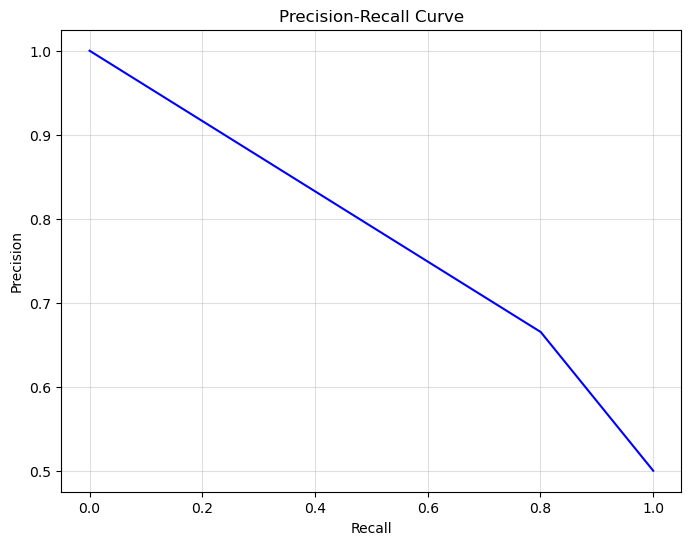

In [122]:
from sklearn.metrics import precision_recall_curve, auc

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(ytest, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR Curve', color='b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(alpha=0.4)

plt.show()